# Sklonowanie i wejście do repozytorium



In [1]:
!git clone https://github.com/shizzeer/credo-classifier.git

Cloning into 'credo-classifier'...
remote: Enumerating objects: 99, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 99 (delta 49), reused 72 (delta 29), pack-reused 0
Receiving objects: 100% (99/99), 9.13 MiB | 9.56 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd credo-classifier

/content/credo-classifier


# Rozpakowanie danych treningowych

In [ ]:
!unzip images.zip

# Usunięcie klasy artefacts ze zbioru danych

In [4]:
!rm -r images/artefacts

# Zaimportowanie bibliotek

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import *
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, \
                                    Input
from tensorflow.keras.models import Sequential, save_model
from sklearn.model_selection import KFold
import pickle
import time

# Module autoreloading
%load_ext autoreload
%autoreload 2

# Załadowanie zestawu danych treningowych i walidacyjnych


In [6]:
BATCH_SIZE = 80
VALIDATION_SPLIT = 0.3
(train_ds, validation_ds) = load_dataset('./images/', batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

Found 1232 files belonging to 3 classes.
Using 863 files for training.
Found 1232 files belonging to 3 classes.
Using 369 files for validation.


# Zmiana kolejności obrazów wewnątrz zbiorów danych - shuffling

W tym momencie zestaw treningowy nie zawiera żadnych obrazów z klasy worms, natomiast cały zestaw walidacyjny składa się z obrazów z klasy worms. Należy więc wymieszać dataset złożony z tych dwóch zestawów danych i rozdzielić obrazy ponownie. Dzięki temu uzyskane zestawy danych będą odpowiednio różnorodne wewnątrz

In [7]:
train_ds_batches = tf.data.experimental.cardinality(train_ds).numpy()
validation_ds_batches = tf.data.experimental.cardinality(validation_ds).numpy()
train_ds_size = train_ds_batches * BATCH_SIZE
validation_ds_size = validation_ds_batches * BATCH_SIZE

concatenated_ds = train_ds.concatenate(validation_ds)
concatenated_ds = concatenated_ds.shuffle(train_ds_size + validation_ds_size, seed=42, reshuffle_each_iteration=False)

Podział na zestaw treningowy i walidacyjny już po dokonanym przetasowaniu

In [8]:
train_ds = concatenated_ds.take(train_ds_batches)
validation_ds = concatenated_ds.skip(train_ds_batches).take(validation_ds_batches)

# Uzyskanie zbioru testowego

Zbiór walidacyjny posłuży dla modelu do optymalizacji hiperparametrów. Potrzebny jest dodatkowy zestaw testowy za pomocą, którego sprawdzimy rzeczywistą umiejętność modelu do generalizacji. Zbiór testowy stanowi 10% zestawu walidacyjnego.

Przed uzyskaniem zestawu testowego, zestaw walidacyjny zostanie przetasowany. Dzięki temu w zestawie testowym powinniśmy otrzymać obrazy o różnych klasach

In [9]:
validation_ds = validation_ds.shuffle(validation_ds_size, seed=42, reshuffle_each_iteration=False)
# 10% test set
test_ds = validation_ds.take(validation_ds_batches // 3)
# 20% validation set
validation_ds = validation_ds.skip(validation_ds_batches // 3)

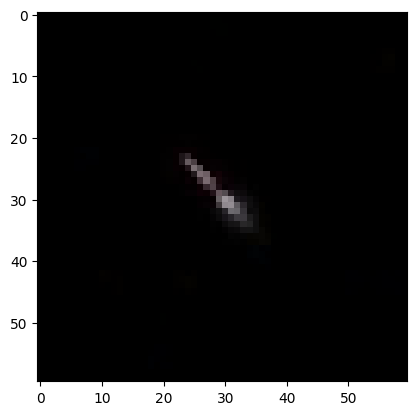

In [ ]:
img_batch = train_ds.take(1)
batch_iterator = iter(img_batch)
image, label = next(batch_iterator)

plt.imshow(image[15].numpy().astype("uint8"))

In [ ]:
np.count_nonzero(image[15].numpy().astype("uint8"))

10800

# Wykres przedstawiający rozkład ilości obrazów na klasę

Pod uwagę wzięty został zbiór danych treningowych

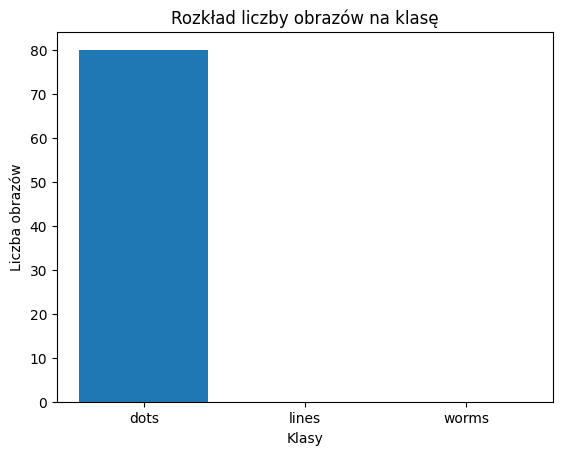

In [ ]:
# Nazwy klas
class_names = ['dots', 'lines', 'worms']

# Dla każdej nazwy klasy musimy mieć ilość sklasyfikowanych obrazow
class_members_count = {class_name: 0 for class_name in class_names}

for _, labels in test_ds:
  for label in labels.numpy():
    class_name = class_names[label]
    class_members_count[class_name] += 1

plt.bar(class_members_count.keys(), class_members_count.values())
plt.xlabel('Klasy')
plt.ylabel('Liczba obrazów')
plt.title('Rozkład liczby obrazów na klasę')
plt.show()

# Preprocessing obrazów

Preprocessing jest na ten moment dokonywany w bardzo prosty aczkolwiek efektywny sposób. Każdy piksel obrazu jest podzielony przez 255 wskutek czego trafia on do zbioru wartości [0, 1].

Dzięki takiej operacji żadna cecha obrazu nie staje się ważniejsza podczas procesu trenowania modelu. W efekcie otrzymamy model, który będzie brał pod uwagę każdy piksel obrazu podczas jego przetwarzania.


In [ ]:
# preprocessed_images = []

# for images, labels in train_ds:
#   for image in images:
#     processed_image = preprocess_image(image)
#     preprocessed_images.append(processed_image)
#preprocessed_train_ds = train_ds.map(preprocess_image)
#preprocessed_validation_ds = validation_ds.map(preprocess_image)

# Model sieci konwolucyjnej (CNN)

Sieć konwolucyjna będzie zdefiniowana w stylu tzw. **feature pyramid**. Oznacza to, że z każdą kolejną warstwą konwolucyjną przestrzeń obrazu będzie się zmniejszać natomiast zwiększać się będzie ilość kanałów.

W ten sposób wczesne warstwy będą wykrywać proste cechy obrazu takie jak na przykład krawędzie natomiast dalsze warstwy będą wykrywać coraz to bardziej skomplikowane i abstrakcyjne cechy.

Z każdą kolejną warstwą idąc głębiej w sieć "oddalamy się" od szczegółów poprzez zmniejszanie przestrzeni obrazu, lecz zwiększamy ilość wykrywanych cech co powinno dać pożądany, opisany powyżej efekt.

Model będzie składał się z warstw:


*   Conv2D
*   MaxPooling2D
*   FC (Fully Connected Network)

## Preprocessing

Przed wprowadzeniem danych do sieci neuronowej w celu jej wytrenowania dane te są przetwarzane w taki sposób, aby ustabilizować proces treningu oraz zwiększyć możliwości generalizacji modelu.

Operacje, które przygotowują dane:

*    Rescaling - każdy piksel obrazu jest przeskalowany do zbioru [0, 1] co stabilizuje proces treningu modelu

*    Random horizontal and vertical flip - odbicie obrazu odpowiednio wzdłuż osi x oraz wzdłuż osi y. Odbicia są dokonywane losowo

*    Random rotation - losowe obrócenie obrazu w pewnym przedziale [-n% * 2pi, n% * 2pi] gdzie n to argument podany do warstwy

*    Random zoom - losowe powiększenie lub pomniejszenie się obrazu w przedziale [n%, n%] gdzie n to argument podany do warstwy







## Stałe

In [12]:
DENSE_UNITS = 20
NUM_EPOCHS = 1500
NUM_CLASSES = 3

In [ ]:
class CNNClasifier(tf.keras.Model):
  def __init__(self, num_filters=30, dense_units=DENSE_UNITS, num_classes=NUM_CLASSES):
    # Wywołanie konstruktora klasy nadrzędnej, czyli tf.keras.Model
    super().__init__()

    # Preprocessing
    self.preprocessing = Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomRotation(0.3),
        tf.keras.layers.RandomZoom(0.3)
    ])

    # Definicja warstw konwolucyjnych
    self.conv1 = Conv2D(num_filters, # number of filters (30)
                        3, # kernel size
                        activation='relu',
                        kernel_initializer="he_normal")

    self.max_pool1 = MaxPooling2D(strides=2)

    self.conv2 = Conv2D(num_filters*2, # number of filters (60)
                        3, # kernel size
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout1 = Dropout(0.2)

    self.max_pool2 = MaxPooling2D(strides=2)

    self.conv3 = Conv2D(num_filters*3, # number of filters (90)
                        3, # kernel size
                        strides=(2,2),
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout2 = Dropout(0.4)

    self.flatten = Flatten()

    self.dense1 = Dense(dense_units,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout3 = Dropout(0.3)

    self.dense2 = Dense(dense_units*0.5,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.output_layer = Dense(num_classes,
                              activation='linear')

    # self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    #                                                      patience=20,
    #                                                      restore_best_weights=True)

  # Forward pass
  def call(self, inputs, training=False):
    x = self.preprocessing(inputs)
    x = self.conv1(x)
    x = self.max_pool1(x)
    x = self.conv2(x)
    if training:
      x = self.dropout1(x)
    x = self.max_pool2(x)
    x = self.conv3(x)
    if training:
      x = self.dropout2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    if training:
      x = self.dropout3(x)
    x = self.dense2(x)
    return self.output_layer(x)

## Trening i kompilacja modelu

In [ ]:
cnn_model = CNNClasifier()

In [ ]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Zapisanie historii uczenia się modelu w celu wizualizacji wykresu funkcji straty od liczby epok

history = cnn_model.fit(train_ds,
    batch_size=80,
    epochs=NUM_EPOCHS,
    validation_data=validation_ds)
    # callbacks=[cnn_model.early_stopping])

In [ ]:
tf.data.experimental.cardinality(validation_ds)
tf.data.experimental.cardinality(train_ds)

<tf.Tensor: shape=(), dtype=int64, numpy=11>

## Zapisanie lub wczytanie historii wytrenowanego modelu

In [ ]:
with open('model_train_history', 'wb') as pickle_f:
  pickle.dump(history.history, pickle_f)

In [ ]:
with open('model_train_history', 'rb') as pickle_f:
  history = pickle.load(pickle_f)

## Załadowanie wytrenowanego modelu

Ta sekcja powinna być używana tylko i wyłącznie wtedy kiedy posiadamy zapisaną architekturą, wagi oraz stan optymalizatora wcześniej wytrenowanego modelu. Wówczas pomija się trening i używa dopasowanego modelu do dokonywania klasyfikacji obrazów

In [ ]:
from tensorflow.keras.models import load_model
cnn_model = load_model('cnn_model')

## Ocena jakości klasyfikacji modelu

Ocena jakości modelu została dokonana za pomocą metody k-fold. Zbiór danych treningowych został podzielony na 5 równych części. Każda z tych części podczas jednej z pięciu iteracji pełniła rolę zbioru walidacyjnego. Model został wytrenowany dokładnie pięć razy za każdym razem z innym podziałem danych na treningowe i walidacyjne. Na koniec została policzona średnia z pięciu ocen jego jakości. Dzięki temu ocena jakości modelu nie jest zależna od pojedynczego podziału zbioru danych na zestaw treningowy i walidacyjny.

In [ ]:
# Konwertowanie datasetów do tablicy numpy
train_images = np.concatenate(list(train_ds.map(lambda img, label: img)))
train_labels = np.concatenate(list(train_ds.map(lambda x, y: y)))
validation_images = np.concatenate(list(validation_ds.map(lambda x, y: x)))
validation_labels = np.concatenate(list(validation_ds.map(lambda x, y: y)))

print('Train images shape: ', train_images.shape)
print('Train labels shape: ', train_labels.shape)
print('Validation images shape: ', validation_images.shape)
print('Validation labels shape: ', validation_labels.shape)

Train images shape:  (849, 60, 60, 3)
Train labels shape:  (849,)
Validation images shape:  (303, 60, 60, 3)
Validation labels shape:  (303,)


In [ ]:
inputs = np.concatenate((train_images, validation_images), axis=0)
targets = np.concatenate((train_labels, validation_labels), axis=0)

print('Inputs shape: ', inputs.shape)
print('Targets shape: ', targets.shape)

Inputs shape:  (1152, 60, 60, 3)
Targets shape:  (1152,)


### K-fold cross validation

Dla k = 5

In [ ]:
score, loss, training_time = kfold(inputs, targets, CNNClasifier)
print('Model accuracy: ', score)
print('Model loss: ', loss)
print('Training time: ', training_time)

Fold 1/5
8/8 [==============================] - 0s 24ms/step - loss: 0.2210 - accuracy: 0.9351
Fold 2/5
8/8 [==============================] - 0s 4ms/step - loss: 0.0966 - accuracy: 0.9437
Fold 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.1831 - accuracy: 0.9217
Fold 4/5
8/8 [==============================] - 0s 4ms/step - loss: 0.2696 - accuracy: 0.9348
Fold 5/5
8/8 [==============================] - 0s 4ms/step - loss: 0.1104 - accuracy: 0.9522
Model accuracy:  0.9374966979026794
Model loss:  0.1761417880654335
Training time:  305.997420835495


In [ ]:
test_ds_eval = cnn_model.evaluate(test_ds)
print("Test Set - Loss:", test_ds_eval[0], "Accuracy:", test_ds_eval[1])

1/1 [==============================] - 0s 296ms/step - loss: 5.5692e-04 - accuracy: 1.0000
Test Set - Loss: 0.0005569181521423161 Accuracy: 1.0


## Wykres funkcji straty od liczby epok

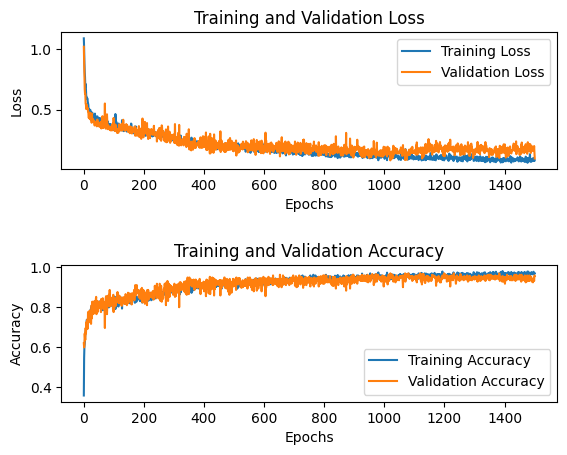

In [ ]:
train_loss = history['loss']
validation_loss = history['val_loss']
epochs = range(1, NUM_EPOCHS + 1)

fig, arr = plt.subplots(2, 1)
arr[0].plot(epochs, train_loss, label='Training Loss')
arr[0].plot(epochs, validation_loss, label='Validation Loss')
arr[0].set_title('Training and Validation Loss')
arr[0].set_xlabel('Epochs')
arr[0].set_ylabel('Loss')
arr[0].legend()

plt.subplots_adjust(hspace=0.7)

train_acc = history['accuracy']
validation_acc = history['val_accuracy']
arr[1].plot(epochs, train_acc, label='Training Accuracy')
arr[1].plot(epochs, validation_acc, label='Validation Accuracy')
arr[1].set_title('Training and Validation Accuracy')
arr[1].set_xlabel('Epochs')
arr[1].set_ylabel('Accuracy')
arr[1].legend()

In [ ]:
cnn_model.summary()

Model: "cnn_clasifier_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 60, 60, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           multiple                  840       
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          multiple                  16260     
                                                                 
 dropout_9 (Dropout)         multiple                  0         
                                                                 
 max_pooling2d_7 (MaxPoolin  multiple                  0         
 g2D)                                              

## Klasyfikacja za pomocą wytrenowanego modelu

Klasyfikacja na zestawie testowym

In [ ]:
#test_ds = test_ds.map(lambda x, y: (x / 255.0, y))
images, labels = next(iter(test_ds))
# Make predictions for the batch
predictions = cnn_model.predict(images)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

rows = 20
cols = 3
fig = plt.figure(figsize=(15,65))
img_idx = 0

for i in range(1, rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    plt.imshow(image[img_idx].numpy().astype("uint8"))
    plt.title(f"True: {labels[img_idx].numpy()}\nPredicted: {predicted_labels[img_idx]}")
    plt.axis('off')
    img_idx += 1
plt.show()

## Zapisanie modelu CONV w formacie SavedModel

Zapisanie modelu obejmuje:


*   Zapis architektury
*   Zapis wag
*   Zapis funkcji straty
*   Zapis stanu optimizera

Po ponownym załadowaniu modelu ze stworzonego katalogu będziemy mieć model gotowy do dokonywania przewidywań


In [ ]:
cnn_model.save('cnn_model')

# Model sieci MLP dla PCA oraz t-SNE

In [10]:
class MLP(tf.keras.Model):
  def __init__(self):
    super().__init__()

    self.flatten = Flatten()

    self.dense1 = Dense(DENSE_UNITS,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.dropout1 = Dropout(0.3)

    self.dense2 = Dense(DENSE_UNITS*0.5,
                        activation='relu',
                        kernel_initializer="he_normal")

    self.output_layer = Dense(NUM_CLASSES,
                              activation='linear')

    self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                          patience=10,
                                                          restore_best_weights=True)

  def call(self, inputs, training=False):
    x = self.flatten(inputs)
    x = self.dense1(x)
    if training:
      x = self.dropout1(x)
    x = self.dense2(x)
    return self.output_layer(x)

In [13]:
mlp = MLP()

In [14]:
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Konwersja Tensorflow dataset -> NumPy dataset

Konwersja ta jest potrzebna, aby zbiory danych mogły zostać przetworzone przez PCA oraz TSNE z biblioteki scikit-learn.

In [15]:
x_train, y_train = convert_tf_ds_to_numpy(train_ds)
x_val, y_val = convert_tf_ds_to_numpy(validation_ds)
x_test, y_test = convert_tf_ds_to_numpy(test_ds)

print('x_train type -> ', type(x_train))
print('y_train type -> ', type(y_train))
print('x_train shape -> ', x_train.shape)
print('y_train shape -> ', y_train.shape)

print('x_val type -> ', type(x_val))
print('y_val type -> ', type(y_val))
print('x_val shape -> ', x_val.shape)
print('y_val shape -> ', y_val.shape)

print('x_test type -> ', type(x_test))
print('y_test type -> ', type(y_test))
print('x_test shape -> ', x_test.shape)
print('y_test shape -> ', y_test.shape)


# W tym momencie datasety są przygotowane do przetworzenia przez PCA oraz t-SNE

x_train type ->  <class 'numpy.ndarray'>
y_train type ->  <class 'numpy.ndarray'>
x_train shape ->  (849, 10800)
y_train shape ->  (849,)
x_val type ->  <class 'numpy.ndarray'>
y_val type ->  <class 'numpy.ndarray'>
x_val shape ->  (303, 10800)
y_val shape ->  (303,)
x_test type ->  <class 'numpy.ndarray'>
y_test type ->  <class 'numpy.ndarray'>
x_test shape ->  (80, 10800)
y_test shape ->  (80,)


# PCA

Metoda redukcji wymiarów Principal Component Analysis jest techniką, która znajduje wzorce wśród cech danych wejściowych na podstawie ich wzajemnej korelacji. Celem metody PCA jest zredukowanie wymiarów danych wejściowych w taki sposób, aby liczba wymiarów była mniejsza bądź równa liczbie wymiarów sprzed tranformacji przy zachowaniu jak największej ilości informacji.

Aby zachować jak największą ilość informacji po zredukowaniu liczby wymiarów PCA skupia się na wyznaczeniu kierunków wektorów, które **maksymalizują** wariancję pomiędzy cechami w wielo-wymiarowej przestrzeni. Następnie dane z wielo-wymiarowej przestrzeni są rzutowane na znalezione wektory skutecznie redukując wymiary przy zachowaniu przeważającej części informacji.

Prostopadłe do siebie wektory z nowej podprzestrzeni, których kierunki wyznaczają największą wariancję między cechami danych są nazywane **principal components** lub po polsku **składowe główne**. **Składowe główne są od siebie niezależne.**

Cechy są rzutowane na utworzone składowe główne. Pierwsza składowa główna odpowiada kierunkowi największej wariancji między cechami danej wejściowej wraz z kolejnymi składowymi głównymi ta wariancja między cechami maleje. W związku z tym pierwsza składowa główna zachowuje najwięcej informacji.

**Pojedyncza składowa główna odpowiada pojedynczemu wymiarowi w nowej przestrzeni.**

## Właściwości PCA

1. Liczba składowych głównych jest <= liczbie wymiarów zestawu danych
2. Składowe główne są do siebie prostopadłe => są niezależne względem siebie
3. Informacja zachowana na składowych głównych **zmniejsza się** wraz z kolejnymi składowymi głównymi

## Jak działa PCA?

PCA wykonuje następujące operacje, aby wyznaczyć składowe główne dla danego zestawu danych.

1. Normalizacja danych
2. Obliczenie macierzy kowariancji
3. Obliczenie wektorów własnych oraz wartości własnych macierzy kowariancji
4. Posortowanie wartości własnych malejąco
5. Wyznaczenie

Macierz kowariancji - wyraża podobieństwo między wszystkimi cechami z zestawu danych. **Dodatnia kowariancja** oznacza, że dwie cechy są do siebie proporcjonalne. **Ujemna kowariancja** - dwie cechy są do siebie odwrotnie proporcjonalne.

Wektory i wartości własne - służą do generowania nowego zestawu danych ze starego zestawu danych. Nowy zestaw danych będzie użyty do utworzenia składowych głównych.

## Model PCA -> MLP -> y

## Import dodatkowych bibliotek

In [ ]:
from sklearn.decomposition import PCA

### Połączenie zestawu treningowego i walidacyjnego

In [ ]:
inputs = np.vstack((x_train, x_val))
targets = np.hstack((y_train, y_val))
print(inputs.shape)
print(targets.shape)

(1152, 10800)
(1152,)


## Preprocessing

Dla PCA nie zostanie zastosowany preprocessing związany z augmentacją danych. Technika augmentacji służy sieciom neuronowym po to, aby wprowadzić różnorodność wśród danych na których sieć się uczy, aby wytrenowany model lepiej generalizował. Innymi słowy - zmuszamy model, aby "patrzył" na całkowicie nowe przykłady danych ulpeszając jego wydajność. Wówczas dla sieci konwolucyjnej takie zabiegi miały sens.

Metoda redukcji wymiarów PCA nie potrzebuje augmentacji danych, ponieważ skupia się na szukaniu maksymalnej wariancji wśród cech obrazów. Różnorodność tych obrazów nie wpłynie na jakość redukcji wymiarów przy użyciu PCA. Dodatkowo do PCA przekazywane są obrazy "wypłaszczone", czyli jedno a nie trzy-wymiarowe co powoduje, że zastosowane w modelu konwolucyjnym techniki augmentacji danych nie zadziałają.

Jedyną formą preprocessingu skopiowaną z modelu konwolucyjnego jest przeskalowanie pikseli w taki sposób, aby każdy z nich znajdował się w przedziale [0, 1].

In [ ]:
inputs = tf.keras.layers.Rescaling(1./255)(inputs)

### PCA -> MLP -> k-fold cross validation

In [ ]:
MIN_N_COMPONENTS = 10
MAX_N_COMPONENTS = 3240 # tyle wymiarów przyjmuje pierwsza warstwa MLP
                        # w modelu konwolucyjnym

num_components = []
scores = []
losses = []

for n_components in range(MIN_N_COMPONENTS, MAX_N_COMPONENTS, 100):
  num_components.append(n_components)
  # Redukcja wymiarów PCA
  pca = PCA(n_components=n_components)
  try:
    pca_transformed_inputs = pca.fit_transform(inputs)
  except ValueError:
    print("n_components have to be less than or equal to min(n_samples, n_features)")
    print(f"min(n_samples, n_features) = {min(inputs.shape[0], inputs.shape[1])}")
    print(f"n_components = {n_components}")
    break
  # Konwersja: EagerTensor -> tablica NumPy
  inputs = inputs.numpy()
  # k-fold cv
  score, loss, training_time = kfold(pca_transformed_inputs, targets, MLP, early_stopping=True)
  scores.append(score)
  losses.append(loss)

  print(f"Number of components -> {n_components}")
  print(f"Score -> {score}")
  print(f"Loss -> {loss}")
  print(f"Training time -> {training_time}")
  print("----------------------------------------------")

Fold 1/5
8/8 [==============================] - 0s 3ms/step - loss: 0.5583 - accuracy: 0.7359
Fold 2/5
8/8 [==============================] - 0s 3ms/step - loss: 0.4406 - accuracy: 0.7922
Fold 3/5
8/8 [==============================] - 0s 4ms/step - loss: 0.4423 - accuracy: 0.7696
Fold 4/5
8/8 [==============================] - 0s 3ms/step - loss: 0.4397 - accuracy: 0.8087
Fold 5/5
8/8 [==============================] - 0s 3ms/step - loss: 0.4176 - accuracy: 0.7957
Number of components -> 10
Score -> 0.7804103136062622
Loss -> 0.4596927106380463
Training time -> 18.788996553421022
----------------------------------------------
Fold 1/5
8/8 [==============================] - 0s 3ms/step - loss: 0.3785 - accuracy: 0.8528
Fold 2/5
8/8 [==============================] - 0s 3ms/step - loss: 0.3957 - accuracy: 0.8182
Fold 3/5
8/8 [==============================] - 0s 3ms/step - loss: 0.6335 - accuracy: 0.8000
Fold 4/5
8/8 [==============================] - 0s 3ms/step - loss: 0.3905 - accura

## Wykres liczby głównych składowych od dokładności modelu

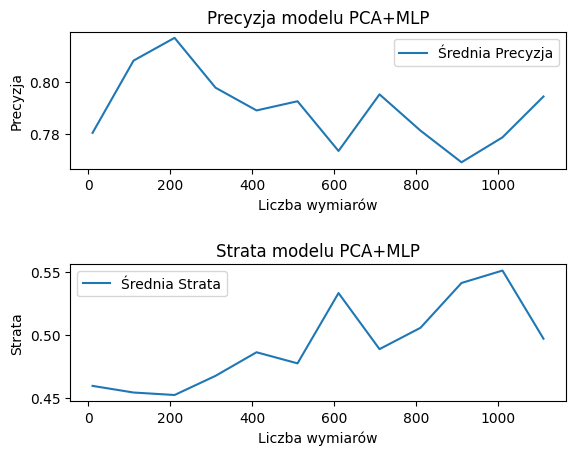

In [ ]:
fig, arr = plt.subplots(2, 1)
arr[0].plot(num_components[:-1], scores, label='Średnia Precyzja')
arr[0].set_title('Precyzja modelu PCA+MLP')
arr[0].set_xlabel('Liczba wymiarów')
arr[0].set_ylabel('Precyzja')
arr[0].legend()

plt.subplots_adjust(hspace=0.7)

arr[1].plot(num_components[:-1], losses, label='Średnia Strata')
arr[1].set_title('Strata modelu PCA+MLP')
arr[1].set_xlabel('Liczba wymiarów')
arr[1].set_ylabel('Strata')
arr[1].legend()

# t-SNE - t-distributed stochastic neighbor embedding

Skrót t-SNE oznacza stochastyczną metodę porządkowania sąsiadów w oparciu o rozkład t. Jest to nieliniowa i nienadzorowana technika stosowana przede wszystkim do eksploracji i wizualizacji danych wielowymiarowych.

Głównym zadaniem t-SNE **jest utrzymanie podobieństw między punktami** w nowej, zredukowanej pod względem wymiarów przestrzeni.

## Właściwości t-SNE

*   Potrafi utrzymywać lokalną stukturę danych, na przykład metoda PCA skupia się na globalnej strukturze danych podczas maksymalizowania wariancji
*   **Utrzymuje najbliższych sąsiadów (utrzymuje podobne ze osbą punkty) w podprzestrzeni o zmniejszonej liczbie wymiarów**
*   Konwertuje odległości euklidesowe pomiędzy punktami w przestrzeni wielo-wymiarowej na gęstość prawdopodobieństwa wyliczaną pomiędzy każdą parą punktów. **Ta gęstość prawdopodobieństwa jest miarą podobieństwa pomiędzy każdą parą punktów w oryginalnej przestrzeni**. Czyli jakie jest prawdopodobieństwo, że punkt x_i jest sąsiadem punktu x_j?

Główną zaletą t-SNE jest to, że **potrafi zachowywać sąsiedztwo punktów** z oryginalnej przestrzeni również w nowej przestrzeni o zredukowanej liczbie wymiarów. Czyli jeżeli 2 punkty były do siebie podobne w oryginalnej przestrzeni to będą do siebie podobne również w nowej przestrzeni

## Kroki, które wykonuje t-SNE

1. Wyznacz odległości pomiędzy obiektami w oryginalnej przestrzeni wielowymiarowej








## Przygotowanie danych dla t-SNE

Połączenie ze sobą zestawu treningowego i walidacyjnego w celu ewaluacji modelu metodą k-fold

In [16]:
inputs = np.vstack((x_train, x_val))
targets = np.hstack((y_train, y_val))
print(inputs.shape)
print(targets.shape)

(1152, 10800)
(1152,)


Normalizacja zestawu danych wejściowych

In [17]:
inputs = tf.keras.layers.Rescaling(1./255)(inputs)

## Ponowna inicjalizacja wag modelu sieci MLP (klasyfikator)

Ponowna inicjalizacja wag modelu jest potrzebna tylko wówczas gdy wcześniej uczony był model PCA+MLP

In [ ]:
mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Ewaluacja modelu t-SNE + MLP

In [19]:
from sklearn.manifold import TSNE

### Efektywnosc modelu w zaleznosci od liczby wymiarow

In [ ]:
MIN_N_COMPONENTS = 10
MAX_N_COMPONENTS = 3240 # tyle wymiarów przyjmuje pierwsza warstwa MLP
                        # w modelu konwolucyjnym

num_components = []
scores = []
losses = []

for n_components in range(MIN_N_COMPONENTS, MAX_N_COMPONENTS, 100):
  print(f'Dla {n_components} wymiarow')

  num_components.append(n_components)
  # Inicjalizacja TSNE
  tsne = TSNE(n_components=n_components, perplexity=40, method='exact')
  try:
    start_time = time.time()
    tsne_transformed_inputs = tsne.fit_transform(inputs)
    end_time = time.time()
    tsne_fit_time = end_time - start_time
  except ValueError:
    print("n_components have to be less than or equal to min(n_samples, n_features)")
    print(f"min(n_samples, n_features) = {min(inputs.shape[0], inputs.shape[1])}")
    print(f"n_components = {n_components}")
    break
  # k-fold cv
  score, loss, mlp_training_time = kfold(tsne_transformed_inputs, targets, MLP, num_epochs=100)
  scores.append(score)
  losses.append(loss)

  print(f"Number of components -> {n_components}")
  print(f"Score -> {score}")
  print(f"Loss -> {loss}")
  print(f"Training time -> {mlp_training_time + tsne_fit_time}")
  print("----------------------------------------------")

Dla 10 wymiarow
Fold 1/5
8/8 [==============================] - 0s 3ms/step - loss: 0.9700 - accuracy: 0.5801
Fold 2/5
8/8 [==============================] - 0s 3ms/step - loss: 1.0032 - accuracy: 0.5498
Fold 3/5
8/8 [==============================] - 0s 3ms/step - loss: 1.0299 - accuracy: 0.4826
Fold 4/5
8/8 [==============================] - 0s 3ms/step - loss: 1.0457 - accuracy: 0.4261
Fold 5/5
8/8 [==============================] - 0s 3ms/step - loss: 0.9617 - accuracy: 0.5435
Number of components -> 10
Score -> 0.5164088070392608
Loss -> 1.0020848989486695
Training time -> 103.64971480369567
----------------------------------------------
Dla 110 wymiarow
Fold 1/5
8/8 [==============================] - 0s 3ms/step - loss: 0.9967 - accuracy: 0.4892
Fold 2/5
8/8 [==============================] - 0s 3ms/step - loss: 1.1012 - accuracy: 0.4762
Fold 3/5
8/8 [==============================] - 0s 4ms/step - loss: 0.8991 - accuracy: 0.6000
Fold 4/5
8/8 [==============================] - 0s

### Efektywnosc modelu w zaleznosci od perplexity

Zalecane perplexity jest z przedzialu od 5 do 50

In [21]:
perplexities = []
scores_perplexity = []
losses_perplexity = []
training_times_perplexity = []

MIN_PERPLEXITY = 5
MAX_PERPLEXITY = 50

for p in range(MIN_PERPLEXITY, MAX_PERPLEXITY, 5):
  print(f'Perplexity -> {p}')
  tsne = TSNE(n_components=10, perplexity=p, method='exact')

  start_time = time.time()
  tsne_transformed_inputs = tsne.fit_transform(inputs)
  end_time = time.time()
  tsne_fit_time = end_time - start_time

  score, loss, mlp_training_time = kfold(tsne_transformed_inputs, targets, MLP, num_epochs=100)

  scores_perplexity.append(score)
  losses_perplexity.append(loss)
  training_times_perplexity.append(mlp_training_time + tsne_fit_time)
  print(f'Score -> {score}')
  print(f'Loss -> {loss}')
  print(f'Training time -> {mlp_training_time + end_time}')
  print("----------------------------------------------")

Perplexity -> 5
Fold 1/5
8/8 [==============================] - 0s 3ms/step - loss: 0.8359 - accuracy: 0.6190
Fold 2/5
8/8 [==============================] - 0s 3ms/step - loss: 0.7711 - accuracy: 0.6407
Fold 3/5
8/8 [==============================] - 0s 3ms/step - loss: 0.7640 - accuracy: 0.6565
Fold 4/5
8/8 [==============================] - 0s 3ms/step - loss: 0.7553 - accuracy: 0.6826
Fold 5/5
8/8 [==============================] - 0s 3ms/step - loss: 0.8249 - accuracy: 0.6261
Score -> 0.6449915409088135
Loss -> 0.7902355432510376
Training time -> 1704628794.7101743
----------------------------------------------
Perplexity -> 10
Fold 1/5
8/8 [==============================] - 0s 3ms/step - loss: 0.7801 - accuracy: 0.6753
Fold 2/5
8/8 [==============================] - 0s 6ms/step - loss: 0.7793 - accuracy: 0.6234
Fold 3/5
8/8 [==============================] - 0s 3ms/step - loss: 0.8090 - accuracy: 0.6261
Fold 4/5
8/8 [==============================] - 0s 3ms/step - loss: 0.7244 - 

## Wykresy straty i precyzji od liczby epok

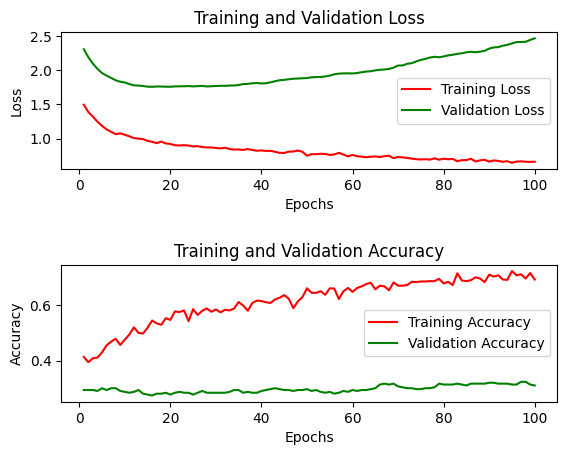

In [ ]:
train_loss = tsne_model_history.history['loss']
validation_loss = tsne_model_history.history['val_loss']
#epochs = range(1, NUM_EPOCHS + 1)
epochs = range(1, 100 + 1)

fig, arr = plt.subplots(2, 1)
arr[0].plot(epochs, train_loss, label='Training Loss', color='red')
arr[0].plot(epochs, validation_loss, label='Validation Loss', color='green')
arr[0].set_title('Training and Validation Loss')
arr[0].set_xlabel('Epochs')
arr[0].set_ylabel('Loss')
arr[0].legend()

plt.subplots_adjust(hspace=0.7)

train_acc = tsne_model_history.history['accuracy']
validation_acc = tsne_model_history.history['val_accuracy']
arr[1].plot(epochs, train_acc, label='Training Accuracy', color='red')
arr[1].plot(epochs, validation_acc, label='Validation Accuracy', color='green')
arr[1].set_title('Training and Validation Accuracy')
arr[1].set_xlabel('Epochs')
arr[1].set_ylabel('Accuracy')
arr[1].legend()

# Czyszczenie środowiska i zapis na Github

In [ ]:
!cp ../drive/MyDrive/Colab\ Notebooks/credo_image_classifier.ipynb .

In [ ]:
!rm -r images

In [ ]:
#!git config --global user.email "eronics00@gmail.com"
#!git config --global user.name "Kamil Szpakowski"
#!git status
!git add *
!git commit -m "K-fold cross validation for t-SNE+MLP"

The following paths are ignored by one of your .gitignore files:
__pycache__
hint: Use -f if you really want to add them.
hint: Turn this message off by running
hint: "git config advice.addIgnoredFile false"
[main c9f5f8f] K-fold cross validation for t-SNE+MLP
 2 files changed, 10 insertions(+), 5 deletions(-)
 rewrite credo_image_classifier.ipynb (94%)


In [ ]:
!git push https://<token>@github.com/shizzeer/credo-classifier.git

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 100.10 KiB | 7.70 MiB/s, done.
Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/shizzeer/credo-classifier.git
   158342a..c9f5f8f  main -> main
